<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/attrition.png?raw=true" width=800 align="left"/>

# 실습 내용

- Attrition 데이터로 모델링합니다.
- KNN 알고리즘으로 모델링합니다.
- 직원 이직 여부를 예측합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'

In [2]:
# 데이터 읽어오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/Attrition_simple2.csv'
data = pd.read_csv(path)

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [3]:
# 상위 몇 개 행 확인
data.head()

,Attrition,Age,DistanceFromHome,EmployeeNumber,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,OverTime,PercentSalaryHike,TotalWorkingYears
0,0,33,7,817,Male,3,Married,11691,No,11,14
1,0,35,18,1412,Male,4,Single,9362,No,11,10
2,0,42,6,1911,Male,1,Married,13348,No,13,18
3,0,46,2,1204,Female,1,Married,17048,No,23,28
4,1,22,4,593,Male,3,Single,3894,No,16,4


**데이터 설명**

- Attrition: 이직 여부 (1: 이직, 0: 잔류)
- Age: 나이
- DistanceFromHome: 집-직장 거리 (단위: 마일)
- EmployeeNumber: 사번	
- Gender: 성별 (Male, Female)
- JobSatisfaction: 직무 만족도(1: Low, 2: Medium, 3: High, 4: Very High)
- MaritalStatus: 결혼 상태 (Single, Married, Divorced)
- MonthlyIncome: 월급 (단위: 달러)
- OverTime: 야근 여부 (Yes, No)
- PercentSalaryHike: 전년 대비 급여 인상율(단위: %)
- TotalWorkingYears: 총 경력 연수

In [4]:
# 기초통계량 확인
data.describe()

,Attrition,Age,DistanceFromHome,EmployeeNumber,JobSatisfaction,MonthlyIncome,PercentSalaryHike,TotalWorkingYears
count,1196.000000,1196.00000,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000
mean,0.163043,36.94398,9.258361,1035.629599,2.716555,6520.104515,15.251672,11.330268
std,0.369560,9.09270,8.166016,604.340130,1.110962,4665.902253,3.625946,7.823821
min,0.000000,18.00000,1.000000,1.000000,1.000000,1009.000000,11.000000,0.000000
25%,0.000000,30.00000,2.000000,507.750000,2.000000,2928.250000,12.000000,6.000000
50%,0.000000,36.00000,7.000000,1028.000000,3.000000,4973.500000,14.000000,10.000000
75%,0.000000,43.00000,14.000000,1581.250000,4.000000,8420.500000,18.000000,15.000000
max,1.000000,60.00000,29.000000,2068.000000,4.000000,19999.000000,25.000000,40.000000


In [5]:
# NaN 값 확인
data.isnull().sum()

Attrition            0
Age                  0
DistanceFromHome     0
EmployeeNumber       0
Gender               0
JobSatisfaction      0
MaritalStatus        0
MonthlyIncome        0
OverTime             0
PercentSalaryHike    0
TotalWorkingYears    0
dtype: int64

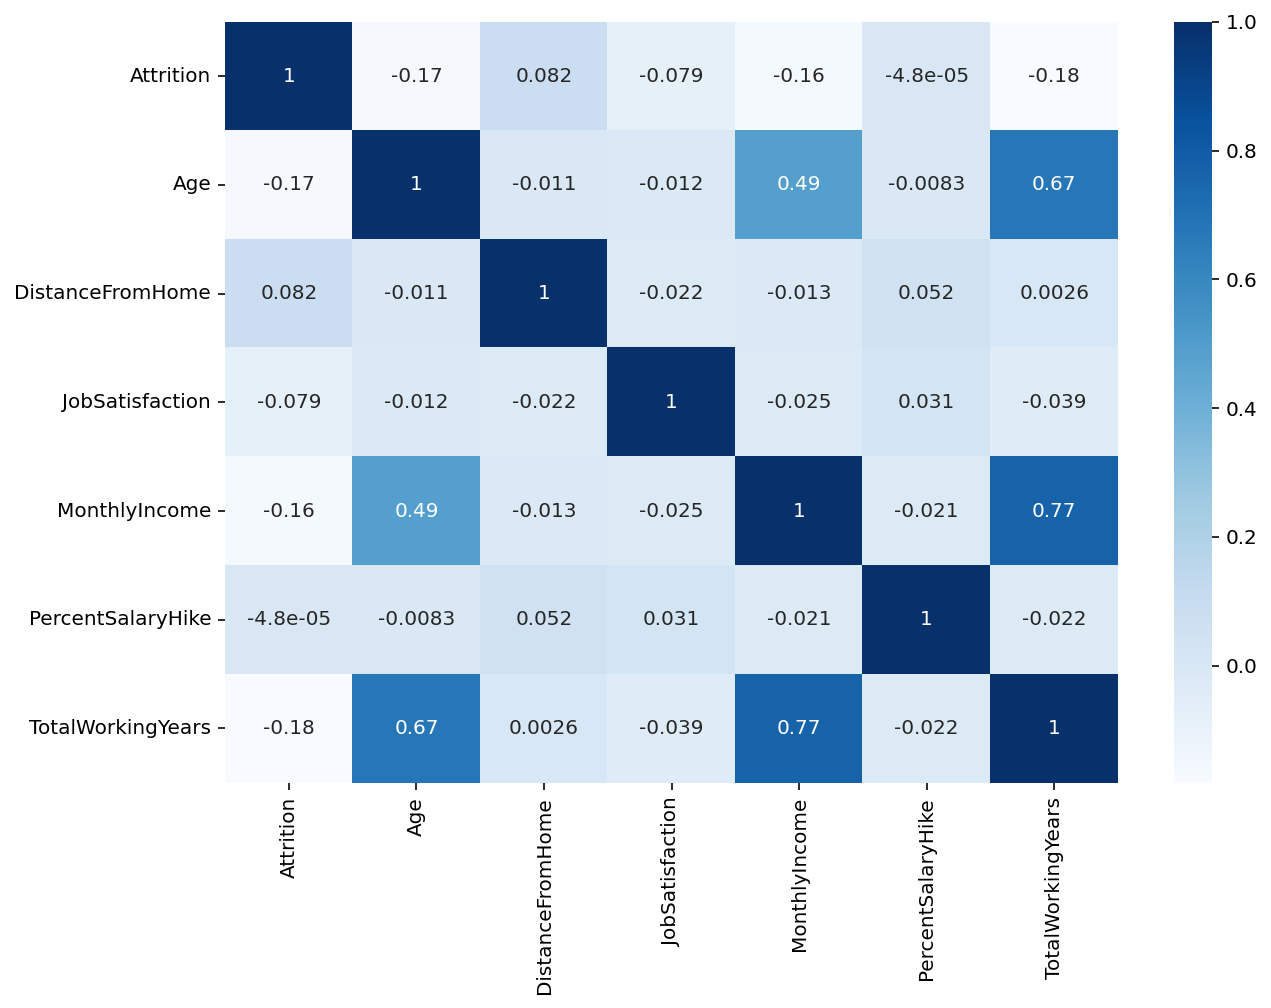

In [59]:
# 상관관계 확인
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(),annot=True,cmap='Blues')
plt.show()

# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) 변수 제거**

- 제거 대상 변수: EmployeeNumber

In [7]:
# 제거 대상: EmployeeNumber
drop_cols = ['EmployeeNumber']

# 변수 제거
data = data.drop(columns=drop_cols,axis=1)

# 확인
data

,Attrition,Age,DistanceFromHome,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,OverTime,PercentSalaryHike,TotalWorkingYears
0,0,33,7,Male,3,Married,11691,No,11,14
1,0,35,18,Male,4,Single,9362,No,11,10
2,0,42,6,Male,1,Married,13348,No,13,18
3,0,46,2,Female,1,Married,17048,No,23,28
4,1,22,4,Male,3,Single,3894,No,16,4
...,...,...,...,...,...,...,...,...,...,...
1191,0,32,5,Female,2,Married,5878,No,12,12
1192,0,27,19,Male,1,Divorced,4066,No,11,7
1193,0,29,9,Male,3,Married,2451,No,18,5
1194,0,29,2,Male,3,Married,4649,No,14,4


**2) x, y 분리**

In [8]:
# target 확인
target = 'Attrition'

# 데이터 분리
X = data.drop(target,axis=1)
y = data[target]

**3) 가변수화**

In [9]:
# 가변수화 대상: Gender, JobSatisfaction, MaritalStatus, OverTime
dumm_cols = ['Gender', 'JobSatisfaction', 'MaritalStatus', 'OverTime']

# 가변수화
X = pd.get_dummies(X,columns=dumm_cols,drop_first=True)

# 확인
X.head(5)

,Age,DistanceFromHome,MonthlyIncome,PercentSalaryHike,TotalWorkingYears,Gender_Male,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,33,7,11691,11,14,1,0,1,0,1,0,0
1,35,18,9362,11,10,1,0,0,1,0,1,0
2,42,6,13348,13,18,1,0,0,0,1,0,0
3,46,2,17048,23,28,0,0,0,0,1,0,0
4,22,4,3894,16,4,1,0,1,0,0,1,0


**4) 정규화**

In [54]:
# 정규화 대상: Age, DistanceFromHome, MonthlyIncome, PercentSalaryHike, TotalWorkingYears
# 더미화된것들도 다 정규화해도 상관없다. 어짜피 결과는 똑같기때문. 

norm_cols = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'PercentSalaryHike', 'TotalWorkingYears']

# 정규화
X = (X - X.min())/(X.max()-X.min())
#  X[norm_cols] = (X[norm_cols] - X[norm_cols].min())/(X[norm_cols].max()-X[norm_cols].min())

# 확인
X.head()

,Age,DistanceFromHome,MonthlyIncome,PercentSalaryHike,TotalWorkingYears,Gender_Male,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,0.357143,0.214286,0.562507,0.000000,0.35,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.404762,0.607143,0.439863,0.000000,0.25,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.571429,0.178571,0.649763,0.142857,0.45,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.666667,0.035714,0.844602,0.857143,0.70,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.095238,0.107143,0.151922,0.357143,0.10,1.0,0.0,1.0,0.0,0.0,1.0,0.0


**5) 학습용, 평가용 데이터 분리**

In [83]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=2022)

# 4.모델링

- 본격적으로 모델을 선언하고 학습하고 평가하는 과정을 진행합니다.

In [84]:
# 1단계: 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [81]:
# 2단계: 선언, 학습, 예측
for n in range(1,10,2):
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(f'이웃수={n}',f1_score(y_test,y_pred,average=None))

이웃수=1 [0.87955182 0.30645161]
이웃수=3 [0.8972973 0.2244898]
이웃수=5 [0.90566038 0.27083333]
이웃수=7 [0.91298527 0.28571429]
이웃수=9 [0.91588785 0.29213483]


In [60]:
# 불균형 데이터 셋. 이직한 사람의 데이터가 상대적으로 너무 작기때문에 1에 대한 재현율은 작을 수 밖에 없음. (학습이 충분히 안됨.) 
# 그렇지만 기업입장에서 이정도의 정확도여도 큰 비용절감을 낼 수도 있기 때문에 절대적인 수치가 중요한 것은 아니다.
# 불균형 데이터 셋에 대한 해결방법은 1. 오버샘플링, 2. 언더샘플링이 있다. 
# 예를들어 비슷한값이 나왔을때 잔류에 데이터가 훨씬 많으면 이 경우에 대해서도 잔류로 예측해버릴 수 있음. (이웃 수 자체가 차이나니깐.. )
# 만약 오버샘플링을 통해 같은값이어도 이웃 수를 확 늘려버리면 더 객관적인 예측이 가능할것. 편향이 적어짐.
y.value_counts()

0    1001
1     195
Name: Attrition, dtype: int64

In [85]:
# 5단계: 평가하기
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[286  14]
 [ 45  14]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.91       300
           1       0.50      0.24      0.32        59

    accuracy                           0.84       359
   macro avg       0.68      0.60      0.61       359
weighted avg       0.80      0.84      0.81       359



In [ ]:
# 남녀 데이터를 나눠서 결과를 도출하면 더 정확도가 높을것 같다. --> 남녀별로 이직에 영향을 주는 피처가 다를 수 있으니까. 
# 혹은 나잇대로 분류하거나, 경력 년수로 분류해서 도출하면 좋지않을까 ?